## Installing all the necessary Packages

In [1]:
# Required for Yahoo Finance model
!pip install yfinance

In [2]:
# Required for ARIMA model
!pip install statsmodels

In [3]:
# Required for the MACD indicator
!pip install ta

## Import All the General and commonly used Packages

In [4]:
# Import all the common modules
import os
import warnings
import requests                 # Needed for the MacroEconomics access.
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Load the Currency Pair into DataFrame

In [5]:
YFinanceData = []
InvestingData = []

# Suppress all warnings
warnings.filterwarnings("ignore")

# Today's Date
TDate = pd.Timestamp.today().normalize()

In [6]:
# Every Currency Pair is a combination of Major and Minor currency
CrncyPair = 'USDCAD'
Major = CrncyPair[0:3]
Minor = CrncyPair[3:]

In [7]:
# DATA SOURCE 01 (Investing.Com)
# ==============================
# Data Source
# Data was downloaded from the link below, and saved as .csv
# https://www.investing.com/currencies/usd-cad-historical-data

# Reading data frame from csv file
InvCrncyPair = Major +'_'+ Minor
InvFileName = InvCrncyPair + '_Historical_Data.csv'

# Check if the Investing.Com CSV file exists
if os.path.exists(InvFileName):
    InvestingData = pd.read_csv(InvFileName)
    InvestingData.drop(InvestingData.columns[[6]], axis=1, inplace=True)
    InvestingData['Vol'] = InvestingData['Vol'].fillna(0)

    # Convert Date string column to Date type
    InvestingData['Date'] = pd.to_datetime(InvestingData['Date'], format='%m/%d/%Y')

    # Set column 'Date' as the index
    InvestingData.set_index('Date', inplace=True)

    # Re-Arrange the columns to allign with that from Source 02 below.
    # Using indexing notation
    InvestingData = InvestingData[['Open', 'High', 'Low', 'Price', 'Vol']]
    InvestingData.drop(columns=['Vol'], inplace=True)
    
    # Also sort the Data by Dates to allign with Source 02 below.
    InvestingData.sort_values(by=['Date'], ascending=[True], inplace=True)
    if (InvestingData.index.max() == TDate):
        InvestingData = InvestingData[InvestingData.index < TDate]
    DataSource = InvestingData.copy()
else:
    # DATA SOURCE 02 (Yahoo Finance)
    # ==============================
    # Download historical data for the Currency Pair using Yahoo Finance
    YHCrncyPair = CrncyPair + '=X'
    YFinanceData = yf.download(YHCrncyPair, start="2000-01-01", end=TDate-timedelta(days=1, hours=-0))

    YFinanceData.rename(columns={"Close": "Price", "Volume": "Vol"}, inplace=True)
    YFinanceData.drop(YFinanceData.columns[[4, 5]], axis=1, inplace=True)

    # Drop rows with missing values
    YFinanceData.dropna(inplace=True)
    DataSource = YFinanceData.copy()

In [8]:
# Free the momory by deleting the DataFrames no longer needed
del YFinanceData
del InvestingData

In [9]:
DataSource.tail(7)

,Open,High,Low,Price
Date,,,,
2024-05-28,1.3637,1.3655,1.3614,1.3645
2024-05-29,1.3644,1.3721,1.3641,1.3714
2024-05-30,1.3718,1.3736,1.3659,1.3678
2024-05-31,1.3679,1.3691,1.3618,1.3626
2024-06-03,1.3628,1.3670,1.3602,1.3627
2024-06-04,1.3628,1.3700,1.3620,1.3678
2024-06-05,1.3678,1.3743,1.3664,1.3692


In [10]:
print(len(DataSource))

11012


## Defining the reqired funtions

In [11]:
def Calculate_RSI(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [12]:
def Calculate_EMA(data, n):
    ema_values = [data[0]]  # Initialize EMA list with the first value
    smoothing_factor = 2 / (n + 1)
    
    for i in range(1, len(data)):
        ema = (data[i] * smoothing_factor) + (ema_values[i - 1] * (1 - smoothing_factor))
        ema_values.append(ema)
    
    return ema_values

In [13]:
def Validation_Dates(MaxDate, NoOfDays):
    # pd.Timestamp.today().normalize()-timedelta(days=1, hours=-0)

    if (MaxDate < pd.Timestamp.today().normalize()):
        Val_Dates = pd.date_range(end=MaxDate+timedelta(days=1, hours=-0), periods=NoOfDays, freq='B')
    else:
        Val_Dates = pd.date_range(end=MaxDate, periods=NoOfDays, freq='B')
    return Val_Dates


In [14]:
# Function to fetch Consumer Price Index (CPI) data
def Get_CPI(Cntry):
    url = 'http://api.worldbank.org/v2/country/' + Cntry + '/indicator/FP.CPI.TOTL'

    # Retrieve current Year
    CurrYr = pd.Timestamp.today().strftime('%Y')
    
    # Parameters to specify the data format and time range
    params = {
        'format': 'json',
        'date': '1982:' + CurrYr,  # specify the time range you're interested in
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()[1]  # extract the actual data from the response
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching inflation rate data: {e}")
        return None

In [15]:
# Function to fetch Imports data
def Get_Imports(Cntry):
    url = 'http://api.worldbank.org/v2/country/' + Cntry + '/indicator/NE.IMP.GNFS.CD'

    # Retrieve current Year
    CurrYr = pd.Timestamp.today().strftime('%Y')
    
    # Parameters to specify the data format and time range
    params = {
        'format': 'json',
        'date': '1982:' + CurrYr,  # specify the time range you're interested in
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()[1]  # extract the actual data from the response
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching inflation rate data: {e}")
        return None

In [16]:
# Function to fetch Exports data
def Get_Exports(Cntry):
    url = 'http://api.worldbank.org/v2/country/' + Cntry + '/indicator/NE.EXP.GNFS.CD'

    # Retrieve current Year
    CurrYr = pd.Timestamp.today().strftime('%Y')
    
    # Parameters to specify the data format and time range
    params = {
        'format': 'json',
        'date': '1982:' + CurrYr,  # specify the time range you're interested in
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()[1]  # extract the actual data from the response
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching inflation rate data: {e}")
        return None

In [17]:
# Function to fetch Government Revenue data
def Get_Revenue(Cntry):
    url = 'http://api.worldbank.org/v2/country/' + Cntry + '/indicator/GC.REV.XGRT.GD.ZS'

    # Retrieve current Year
    CurrYr = pd.Timestamp.today().strftime('%Y')
    
    # Parameters to specify the data format and time range
    params = {
        'format': 'json',
        'date': '1982:' + CurrYr,  # specify the time range you're interested in
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()[1]  # extract the actual data from the response
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching inflation rate data: {e}")
        return None

In [18]:
# Function to fetch Interest Rate data
def Get_Interest_Rate(Cntry):
    url = 'http://api.worldbank.org/v2/country/' + Cntry + '/indicator/FR.INR.RINR'
    
    # Retrieve current Year
    CurrYr = pd.Timestamp.today().strftime('%Y')
    
    # Parameters to specify the data format and time range
    params = {
        'format': 'json',
        'date': '1982:' + CurrYr,  # specify the time range you're interested in
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()[1]  # extract the actual data from the response
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching interest rate data: {e}")
        return None

In [19]:
# Function to fetch Inflation Rate data
def Get_Inflation_Rate(Cntry):
    url = 'http://api.worldbank.org/v2/country/' + Cntry + '/indicator/FP.CPI.TOTL.ZG'

    # Retrieve current Year
    CurrYr = pd.Timestamp.today().strftime('%Y')
    
    # Parameters to specify the data format and time range
    params = {
        'format': 'json',
        'date': '1982:' + CurrYr,  # specify the time range you're interested in
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()[1]  # extract the actual data from the response
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching inflation rate data: {e}")
        return None

In [20]:
# Function to fetch GDP Ratio data
def Get_GDP_Ratio(Cntry):
    url = 'http://api.worldbank.org/v2/country/' + Cntry + '/indicator/NY.GDP.MKTP.CD'

    # Retrieve current Year
    CurrYr = pd.Timestamp.today().strftime('%Y')
    
    # Parameters to specify the data format and time range
    params = {
        'format': 'json',
        'date': '1982:' + CurrYr,  # specify the time range you're interested in
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()[1]  # extract the actual data from the response
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching inflation rate data: {e}")
        return None

In [21]:
# Function to fetch GDP Growth data
def Get_GDP_Growth(Cntry):
    url = 'http://api.worldbank.org/v2/country/' + Cntry + '/indicator/NY.GDP.MKTP.KD.ZG'

    # Retrieve current Year
    CurrYr = pd.Timestamp.today().strftime('%Y')
    
    # Parameters to specify the data format and time range
    params = {
        'format': 'json',
        'date': '1982:' + CurrYr,  # specify the time range you're interested in
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()[1]  # extract the actual data from the response
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching inflation rate data: {e}")
        return None

In [22]:
# Function to fetch UnEmployment Rate data
def Get_UnEmploy_Rate(Cntry):
    url = 'http://api.worldbank.org/v2/country/' + Cntry + '/indicator/SL.UEM.TOTL.ZS'

    # Retrieve current Year
    CurrYr = pd.Timestamp.today().strftime('%Y')
    
    # Parameters to specify the data format and time range
    params = {
        'format': 'json',
        'date': '1982:' + CurrYr,  # specify the time range you're interested in
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()[1]  # extract the actual data from the response
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching inflation rate data: {e}")
        return None

In [23]:
def Get_IncrementValue(StartingDate, EndingDate, StartVal, EndVal):
    import math
    
    # Generate business days for the year
    Business_Days = pd.date_range(start=StartingDate+timedelta(days=1, hours=-0), end=EndingDate-timedelta(days=1, hours=-0), freq='B')

    # Calculate the incremental value
    SVal = value = float(StartVal)
    EVal = value = float(EndVal)
    if ((math.isnan(SVal)) & (math.isnan(EVal))):
        Incremental_Value = 0
        Null = 1
    elif ((not math.isnan(SVal)) & (math.isnan(EVal))):
        Incremental_Value = StartVal
        Null = 1
    elif ((math.isnan(SVal)) & (not math.isnan(EVal))):
        Incremental_Value = EndVal
        Null = 1
    else:
        Incremental_Value = (EndVal - StartVal) / len(Business_Days)
        Null = 0

    return Null, Incremental_Value

In [24]:
def Get_MacroEcons(Cntry):
    # Get MacroEconomics Data
    CPI_Data = Get_CPI(Cntry)
    IntRate_Data = Get_Interest_Rate(Cntry)
    InfRate_Data = Get_Inflation_Rate(Cntry)
    Import_Data = Get_Imports(Cntry)
    Export_Data = Get_Exports(Cntry)
    Revenue_Data = Get_Revenue(Cntry)
    GDPRatio_Data = Get_GDP_Ratio(Cntry)
    GDPGrowth_Data = Get_GDP_Growth(Cntry)
    UnEmployRate_Data = Get_UnEmploy_Rate(Cntry)

    # Extract the 'Value' column only.
    CPI = CPI_Data['value'].copy()
    IntR = IntRate_Data['value'].copy()
    InfR = InfRate_Data['value'].copy()
    Import = Import_Data['value'].copy()
    Export = Export_Data['value'].copy()
    Revenue = Revenue_Data['value'].copy()
    GDPRatio = GDPRatio_Data['value'].copy()
    GDPGrowth = GDPGrowth_Data['value'].copy()
    UnEmployRate = UnEmployRate_Data['value'].copy()

    # Define column names
    Cols = ['value']
    # Create DataFrame
    CPIData = pd.DataFrame(CPI, columns=Cols)
    IntRData = pd.DataFrame(IntR, columns=Cols)
    InfRData = pd.DataFrame(InfR, columns=Cols)
    ImportData = pd.DataFrame(Import, columns=Cols)
    ExportData = pd.DataFrame(Export, columns=Cols)
    RevenueData = pd.DataFrame(Revenue, columns=Cols)
    GDPRatioData = pd.DataFrame(GDPRatio, columns=Cols)
    GDPGrowthData = pd.DataFrame(GDPGrowth, columns=Cols)
    UnEmployRateData = pd.DataFrame(UnEmployRate, columns=Cols)

    CPIData.reset_index(inplace=True)
    IntRData.reset_index(inplace=True)
    InfRData.reset_index(inplace=True)
    ImportData.reset_index(inplace=True)
    ExportData.reset_index(inplace=True)
    RevenueData.reset_index(inplace=True)
    GDPRatioData.reset_index(inplace=True)
    GDPGrowthData.reset_index(inplace=True)
    UnEmployRateData.reset_index(inplace=True)

    CPIData.rename(columns={'date': 'Date', 'value': 'CPI'}, inplace=True)
    IntRData.rename(columns={'date': 'Date2', 'value': 'IntRate'}, inplace=True)
    InfRData.rename(columns={'date': 'Date2', 'value': 'InfRate'}, inplace=True)
    ImportData.rename(columns={'date': 'Date2', 'value': 'Import'}, inplace=True)
    ExportData.rename(columns={'date': 'Date2', 'value': 'Export'}, inplace=True)
    RevenueData.rename(columns={'date': 'Date2', 'value': 'Revenue'}, inplace=True)
    GDPRatioData.rename(columns={'date': 'Date2', 'value': 'GDPRatio'}, inplace=True)
    GDPGrowthData.rename(columns={'date': 'Date2', 'value': 'GDPGrowth'}, inplace=True)
    UnEmployRateData.rename(columns={'date': 'Date2', 'value': 'UnEmployRate'}, inplace=True)

    # Merging the MacroEconomics Data together
    # Concatenate columns along axis 1 (columns)
    MacroEcons = pd.concat([CPIData, IntRData], axis=1); MacroEcons.drop(['Date2'], axis=1, inplace=True)
    MacroEcons = pd.concat([MacroEcons, InfRData], axis=1); MacroEcons.drop(['Date2'], axis=1, inplace=True)
    MacroEcons = pd.concat([MacroEcons, ImportData], axis=1); MacroEcons.drop(['Date2'], axis=1, inplace=True)
    MacroEcons = pd.concat([MacroEcons, ExportData], axis=1); MacroEcons.drop(['Date2'], axis=1, inplace=True)
    MacroEcons = pd.concat([MacroEcons, RevenueData], axis=1); MacroEcons.drop(['Date2'], axis=1, inplace=True)
    MacroEcons = pd.concat([MacroEcons, GDPRatioData], axis=1); MacroEcons.drop(['Date2'], axis=1, inplace=True)
    MacroEcons = pd.concat([MacroEcons, GDPGrowthData], axis=1); MacroEcons.drop(['Date2'], axis=1, inplace=True)
    MacroEcons = pd.concat([MacroEcons, UnEmployRateData], axis=1); MacroEcons.drop(['Date2'], axis=1, inplace=True)

    l = len(MacroEcons)
    while (l > 1):
        CPI_IncrementValue = 0.00
        IntRate_IncrementValue = 0.00
        InfRate_IncrementValue = 0.00
        Import_IncrementValue = 0.00
        Export_IncrementValue = 0.00
        Revenue_IncrementValue = 0.00
        GDPRatio_IncrementValue = 0.00
        GDPGrowth_IncrementValue = 0.00
        UnEmployRate_IncrementValue = 0.00

        # Date Array
        Dtt1 = MacroEcons.iloc[l-1:l, 0].item()
        Dtt2 = MacroEcons.iloc[l-2:l-1, 0].item()
        
        # We call a function to calculate the Increment Size
        CPI_Null, CPI_IncrementSize = Get_IncrementValue(Dtt1, Dtt2, MacroEcons.iloc[l-1:l, 1].item(),  MacroEcons.iloc[l-2:l-1, 1].item())
        IntRate_Null, IntRate_IncrementSize = Get_IncrementValue(Dtt1, Dtt2, MacroEcons.iloc[l-1:l, 2].item(),  MacroEcons.iloc[l-2:l-1, 2].item())
        InfRate_Null, InfRate_IncrementSize = Get_IncrementValue(Dtt1, Dtt2, MacroEcons.iloc[l-1:l, 3].item(),  MacroEcons.iloc[l-2:l-1, 3].item())
        Import_Null, Import_IncrementSize = Get_IncrementValue(Dtt1, Dtt2, MacroEcons.iloc[l-1:l, 4].item(),  MacroEcons.iloc[l-2:l-1, 4].item())
        Export_Null, Export_IncrementSize = Get_IncrementValue(Dtt1, Dtt2, MacroEcons.iloc[l-1:l, 5].item(),  MacroEcons.iloc[l-2:l-1, 5].item())
        Revenue_Null, Revenue_IncrementSize = Get_IncrementValue(Dtt1, Dtt2, MacroEcons.iloc[l-1:l, 6].item(),  MacroEcons.iloc[l-2:l-1, 6].item())
        GDPRatio_Null, GDPRatio_IncrementSize = Get_IncrementValue(Dtt1, Dtt2, MacroEcons.iloc[l-1:l, 7].item(),  MacroEcons.iloc[l-2:l-1, 7].item())
        GDPGrowth_Null, GDPGrowth_IncrementSize = Get_IncrementValue(Dtt1, Dtt2, MacroEcons.iloc[l-1:l, 8].item(),  MacroEcons.iloc[l-2:l-1, 8].item())
        UnEmployRate_Null, UnEmployRate_IncrementSize = Get_IncrementValue(Dtt1, Dtt2, MacroEcons.iloc[l-1:l, 9].item(),  MacroEcons.iloc[l-2:l-1, 9].item())
        
        Data = pd.date_range(start = Dtt1+timedelta(days=1, hours=-0), end = Dtt2-timedelta(days=1, hours=-0), freq="B")

        # Define column names
        Cols = ['Date']
        
        # Create Daily DataFrame
        for Dt in Data:
            Dt = np.array([Dt])
            MacroEconsDays = pd.DataFrame(Dt, columns=Cols)

            if (CPI_Null == 0):
                CPI_IncrementValue = CPI_IncrementValue + CPI_IncrementSize
            if (IntRate_Null == 0):
                IntRate_IncrementValue = IntRate_IncrementValue + IntRate_IncrementSize
            if (InfRate_Null == 0):
                InfRate_IncrementValue = InfRate_IncrementValue + InfRate_IncrementSize
            if (Import_Null == 0):
                Import_IncrementValue = Import_IncrementValue + Import_IncrementSize
            if (Export_Null == 0):
                Export_IncrementValue = Export_IncrementValue + Export_IncrementSize
            if (Revenue_Null == 0):
                Revenue_IncrementValue = Revenue_IncrementValue + Revenue_IncrementSize
            if (GDPRatio_Null == 0):
                GDPRatio_IncrementValue = GDPRatio_IncrementValue + GDPRatio_IncrementSize
            if (GDPGrowth_Null == 0):
                GDPGrowth_IncrementValue = GDPGrowth_IncrementValue + GDPGrowth_IncrementSize
            if (UnEmployRate_Null == 0):
                UnEmployRate_IncrementValue = UnEmployRate_IncrementValue + UnEmployRate_IncrementSize

            MacroEconsDays['CPI'] = MacroEcons.iloc[l-1:l, 1].item() + CPI_IncrementValue
            MacroEconsDays['IntRate'] = MacroEcons.iloc[l-1:l, 2].item() + IntRate_IncrementValue
            MacroEconsDays['InfRate'] = MacroEcons.iloc[l-1:l, 3].item() + InfRate_IncrementValue
            MacroEconsDays['Import'] = MacroEcons.iloc[l-1:l, 4].item() + Import_IncrementValue
            MacroEconsDays['Export'] = MacroEcons.iloc[l-1:l, 5].item() + Export_IncrementValue
            MacroEconsDays['Revenue'] = MacroEcons.iloc[l-1:l, 6].item() + Revenue_IncrementValue
            MacroEconsDays['GDPRatio'] = MacroEcons.iloc[l-1:l, 7].item() + GDPRatio_IncrementValue
            MacroEconsDays['GDPGrowth'] = MacroEcons.iloc[l-1:l, 8].item() + GDPGrowth_IncrementValue
            MacroEconsDays['UnEmployRate'] = MacroEcons.iloc[l-1:l, 9].item() + UnEmployRate_IncrementValue

            # Adding Records
            # Concatenate rows along axis 0 (columns)
            MacroEcons = pd.concat([MacroEcons, MacroEconsDays], axis=0)
            del MacroEconsDays

        l -= 1
        del Data
        #del MacroEconsDays
        
    if(Dtt2.strftime('%Y') < pd.Timestamp.today().strftime('%Y')):
        # Date Array
        l += 1
        Dtt1 = Dtt2
        Dtt2 = pd.Timestamp.today()
        Data = pd.date_range(start = Dtt1+timedelta(days=1, hours=-0), end = Dtt2, freq="B")

        # Define column names
        Cols = ['Date']

        # Create Daily DataFrame
        for Dt in Data:
            Dt = np.array([Dt])
            MacroEconsDays = pd.DataFrame(Dt, columns=Cols)

            if (CPI_Null == 0):
                CPI_IncrementValue = CPI_IncrementValue + CPI_IncrementSize
            if (IntRate_Null == 0):
                IntRate_IncrementValue = IntRate_IncrementValue + IntRate_IncrementSize
            if (InfRate_Null == 0):
                InfRate_IncrementValue = InfRate_IncrementValue + InfRate_IncrementSize
            if (Import_Null == 0):
                Import_IncrementValue = Import_IncrementValue + Import_IncrementSize
            if (Export_Null == 0):
                Export_IncrementValue = Export_IncrementValue + Export_IncrementSize
            if (Revenue_Null == 0):
                Revenue_IncrementValue = Revenue_IncrementValue + Revenue_IncrementSize
            if (GDPRatio_Null == 0):
                GDPRatio_IncrementValue = GDPRatio_IncrementValue + GDPRatio_IncrementSize
            if (GDPGrowth_Null == 0):
                GDPGrowth_IncrementValue = GDPGrowth_IncrementValue + GDPGrowth_IncrementSize
            if (UnEmployRate_Null == 0):
                UnEmployRate_IncrementValue = UnEmployRate_IncrementValue + UnEmployRate_IncrementSize

            MacroEconsDays['CPI'] = MacroEcons.iloc[l-1:l, 1].item() + CPI_IncrementValue
            MacroEconsDays['IntRate'] = MacroEcons.iloc[l-1:l, 2].item() + IntRate_IncrementValue
            MacroEconsDays['InfRate'] = MacroEcons.iloc[l-1:l, 3].item() + InfRate_IncrementValue
            MacroEconsDays['Import'] = MacroEcons.iloc[l-1:l, 4].item() + Import_IncrementValue
            MacroEconsDays['Export'] = MacroEcons.iloc[l-1:l, 5].item() + Export_IncrementValue
            MacroEconsDays['Revenue'] = MacroEcons.iloc[l-1:l, 6].item() + Revenue_IncrementValue
            MacroEconsDays['GDPRatio'] = MacroEcons.iloc[l-1:l, 7].item() + GDPRatio_IncrementValue
            MacroEconsDays['GDPGrowth'] = MacroEcons.iloc[l-1:l, 8].item() + GDPGrowth_IncrementValue
            MacroEconsDays['UnEmployRate'] = MacroEcons.iloc[l-1:l, 9].item() + UnEmployRate_IncrementValue

            # Adding Records
            # Concatenate rows along axis 0 (columns)
            MacroEcons = pd.concat([MacroEcons, MacroEconsDays], axis=0)
            del MacroEconsDays
            
        del Data
        
    # Set all the Null cells to 0
    NullRep = 0
    MacroEcons['CPI'] = MacroEcons['CPI'].fillna(NullRep)
    MacroEcons['IntRate'] = MacroEcons['IntRate'].fillna(NullRep)
    MacroEcons['InfRate'] = MacroEcons['InfRate'].fillna(NullRep)
    MacroEcons['Import'] = MacroEcons['Import'].fillna(NullRep)
    MacroEcons['Export'] = MacroEcons['Export'].fillna(NullRep)
    MacroEcons['Revenue'] = MacroEcons['Revenue'].fillna(NullRep)
    MacroEcons['GDPRatio'] = MacroEcons['GDPRatio'].fillna(NullRep)
    MacroEcons['GDPGrowth'] = MacroEcons['GDPGrowth'].fillna(NullRep)
    MacroEcons['UnEmployRate'] = MacroEcons['UnEmployRate'].fillna(NullRep)
    
    return MacroEcons

In [25]:
def Get_Cntry_Code(Crncy):
    # Source = https://www.att.com/support_media/images/pdf/Country_Code_List.pdf
    match Crncy:
        case 'USD':
            return 'USA'
        case 'CAD':
            return 'CAN'
        case 'GBP':
            return 'GBR'
        case 'EUR':
            return 'ITA'
        case 'AUD':
            return 'AUS'
        case 'JPY':
            return 'JPN'
        case 'NZD':
            return 'NZL'
        case 'CHF':
            return 'CHE'
        case 'NGN':
            return 'NGA'
        case default:
            return NaN

In [26]:
def Plot_TrainTest(CrncyPair, Y_Train, Y_Test):
    # Plot Train and Test prices
    plt.figure(figsize=(10, 6))
    plt.plot(Y_Train.index, Y_Train.values, label='Training Data', color='blue')
    plt.plot(Y_Test.index, Y_Test.values, label='Test Data', color='orange')
    plt.title('The Train/Test data for ' + CrncyPair + ' Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

In [27]:
def Rpt_Evaluate_Plot(CrncyPair, Model_Name, Model_Code, Y_Train, Y_Test, Y_Pred, Future_Preds):
    # Evaluate the model
    mae = mean_absolute_error(Y_Test, Y_Pred)
    print("Mean Absolute Error: {:.6f}".format(mae))
    # ============================================
    mse = mean_squared_error(Y_Test, Y_Pred)
    print("Mean Squared Error: {:.6f}".format(mse))
    # ===================================================
    rmse = np.sqrt(mse)
    print('Root Mean Squared Error: {:.6f}'.format(rmse))
    # ============================================
    r2 = r2_score(Y_Test, Y_Pred)
    print("R-squared (R2) score: {:.6f}".format(r2))
    # ============================================
    print('Future Predictions', Future_Preds)

    # Plotting the graph
    Future_Dates = pd.date_range(start=ValidationDates[0], periods=len(Future_Preds), freq="B")

    # Plot Actual vs Predicted prices
    plt.figure(figsize=(12, 6))
    plt.plot(Validation.Date, Validation.Price, label='Actual Data', color='blue')
    plt.plot(Future_Dates, Future_Preds, label='Predicted Data', color='green')
    plt.scatter(Validation.Date, Validation.Price, s=10, color='red')
    plt.scatter(Future_Dates, Future_Preds, s=10, color='red')
    plt.title(Model_Name + ': Actual vs Predicted values for ' + CrncyPair + ' Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

    # Inserting Record into the DataFrame
    Models_Compare.loc[len(Models_Compare.index)] = [Model_Name, Model_Code, mae, mse, rmse, r2]

## The Models

In [28]:
# Write the Performance Metrics to a DataFrame for easy comparism.
# Define column names
Cols = ['ModelName', 'ModelCode', 'MAE', 'MSE', 'RMSE', 'R2']

# Create DataFrame
Models_Compare = pd.DataFrame(columns = Cols)

In [29]:
# Model Common/Global parameters & Modules
# Here, I choose to use 15% of my data for Testing and the remaing 95% for Training.
TestPercent = 0.15
TrainPercent = 1.0 - TestPercent

# Predictions
NoOfDays = 10
ValidationDates = Validation_Dates(DataSource.index.max(), NoOfDays)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Cut out Data for Validation

In [30]:
# Filter the DataFrame for rows where the index (Date) is greater than or equal to ValidationDates[0]
Filter = DataSource.loc[DataSource.index >= ValidationDates[0]]

# Create the Validation DataFrame with the Date and Price columns
Validation = Filter.reset_index()[['Date', 'Price']]
Validation.head(3)

,Date,Price
0,2024-05-24,1.3661
1,2024-05-27,1.3632
2,2024-05-28,1.3645


In [31]:
# Delete these Validation rows from the 'DataSource' DataFrame
DataSource = DataSource[DataSource.index < ValidationDates[0]]
DataSource.tail(3)

,Open,High,Low,Price
Date,,,,
2024-05-21,1.3625,1.3677,1.3614,1.3652
2024-05-22,1.3655,1.3700,1.3623,1.3693
2024-05-23,1.3694,1.3745,1.3656,1.3729


#### Adding the Statistical Data to the DataSource

In [32]:
# Feature Engineering: Calculate rolling averages, momentum indicators, etc.
from ta.trend import MACD
DataSource['SMA_20'] = DataSource['Price'].rolling(window=20).mean()
DataSource['SMA_50'] = DataSource['Price'].rolling(window=50).mean()
DataSource['RSI'] = Calculate_RSI(DataSource['Price'], window=14)
DataSource['EMA_12'] = Calculate_EMA(DataSource['Price'], 12)
DataSource['EMA_26'] = Calculate_EMA(DataSource['Price'], 26)
DataSource['MACD'] = MACD(DataSource['Price']).macd()

# Drop rows with missing values
DataSource.dropna(inplace=True)

#### Get the MacroEconomics Data

In [33]:
%%time
# Get the MacroEconomics Data
Major_MacroEcons = Get_MacroEcons(Get_Cntry_Code(Major))
Major_MacroEcons.rename(columns={"CPI": "Major_CPIs", "IntRate": "Major_IntRates", "InfRate": "Major_InfRates", "Import": "Major_Imports", "Export": "Major_Exports", "Revenue": "Major_Revenues", "GDPRatio": "Major_GDPRatios", "GDPGrowth": "Major_GDPGrowths", "UnEmployRate": "Major_UnEmployRates"}, inplace=True)

Minor_MacroEcons = Get_MacroEcons(Get_Cntry_Code(Minor))
Minor_MacroEcons.rename(columns={"CPI": "Minor_CPIs", "IntRate": "Minor_IntRates", "InfRate": "Minor_InfRates", "Import": "Minor_Imports", "Export": "Minor_Exports", "Revenue": "Minor_Revenues", "GDPRatio": "Minor_GDPRatios", "GDPGrowth": "Minor_GDPGrowths", "UnEmployRate": "Minor_UnEmployRates"}, inplace=True)

# Merge the MacroEconomic datasets on a common key, such as Date
MacroEcons = pd.merge(Major_MacroEcons, Minor_MacroEcons, on='Date')

# Free the memory.
del Major_MacroEcons, Minor_MacroEcons

CPU times: user 47.4 s, sys: 45.4 ms, total: 47.4 s
Wall time: 51.1 s


#### Mering the MacroEconomics Data with the DataSource

In [34]:
%%time
# Merge the DataSource with the MacroEconomic dataset on a common key, such as Date
FxPair_Data = pd.merge(DataSource, MacroEcons, how='left', on=['Date'])

# Set NaN to Zero, and column 'Date' as the index
FxPair_Data.fillna(0, inplace=True)
FxPair_Data.set_index('Date', inplace=True)

# Free the memory.
del DataSource, MacroEcons

CPU times: user 7.02 ms, sys: 4.98 ms, total: 12 ms
Wall time: 10.9 ms


#### Split the Data and Plot Train/Test

In [35]:
# Split the data into features (X) and target variable (y)
Features = ['Open', 'High', 'Low', 'SMA_20', 'SMA_50', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'Major_CPIs', 'Major_IntRates', 'Major_InfRates', 'Major_Imports', 'Major_Exports', 'Major_Revenues', 'Major_GDPRatios', 'Major_GDPGrowths', 'Major_UnEmployRates', 'Minor_CPIs', 'Minor_IntRates', 'Minor_InfRates', 'Minor_Imports', 'Minor_Exports', 'Minor_Revenues', 'Minor_GDPRatios', 'Minor_GDPGrowths', 'Minor_UnEmployRates']
X = FxPair_Data[Features]  # Features
y = FxPair_Data['Price']  # Target variable (FxPair closing prices)

# Split data into training and testing sets or Training and Forecasting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TestPercent, random_state=None, shuffle=False)

# Free the memory
del Features

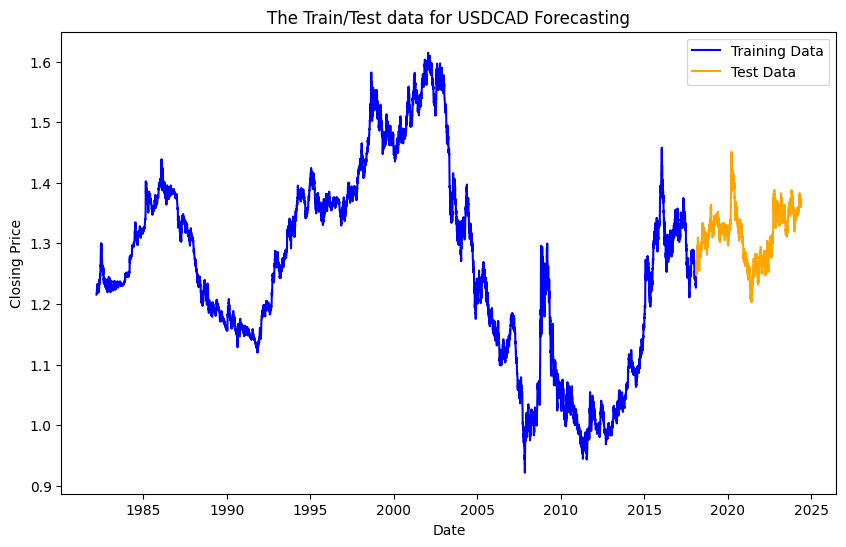

In [36]:
# Plotting the Train/Test Data
Plot_TrainTest(CrncyPair, y_train, y_test)

#### Linear Regression Model

In [37]:
from sklearn.linear_model import LinearRegression

Mean Absolute Error: 0.002145
Mean Squared Error: 0.000007
Root Mean Squared Error: 0.002679
R-squared (R2) score: 0.996026
Future Predictions [1.36669933 1.3689855  1.36685305 1.36245209 1.36346185 1.36357087
 1.36188832 1.36593501 1.36751273 1.37121601]


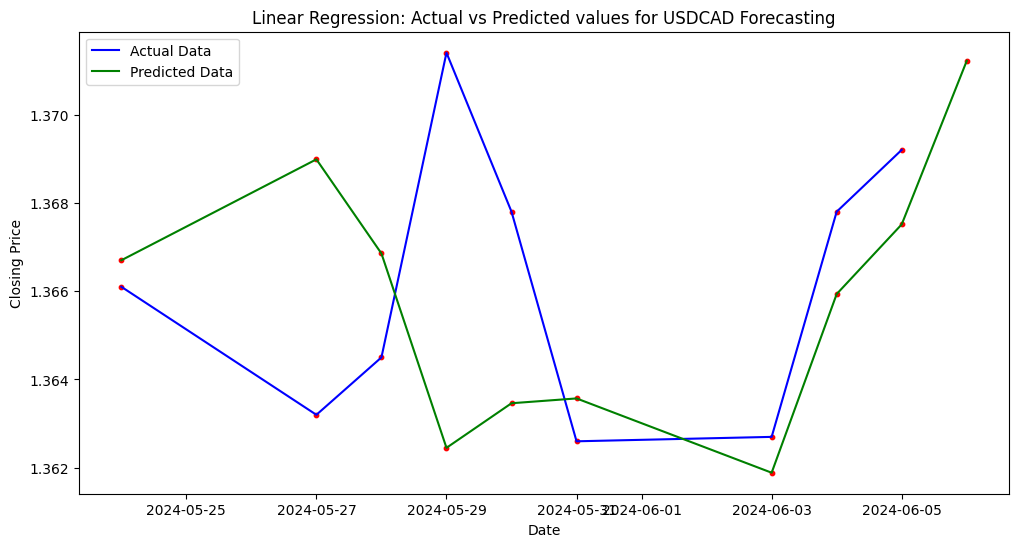

CPU times: user 287 ms, sys: 1.2 s, total: 1.48 s
Wall time: 187 ms


In [38]:
%%time
# Instantiate Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[len(y_pred)-(NoOfDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'LNR'
ModelName = 'Linear Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### Random Forest Regressor Model

In [39]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier

Mean Absolute Error: 0.002289
Mean Squared Error: 0.000009
Root Mean Squared Error: 0.002986
R-squared (R2) score: 0.995061
Future Predictions [1.366994 1.36784  1.366717 1.361755 1.361316 1.362256 1.361401 1.364845
 1.366264 1.369925]


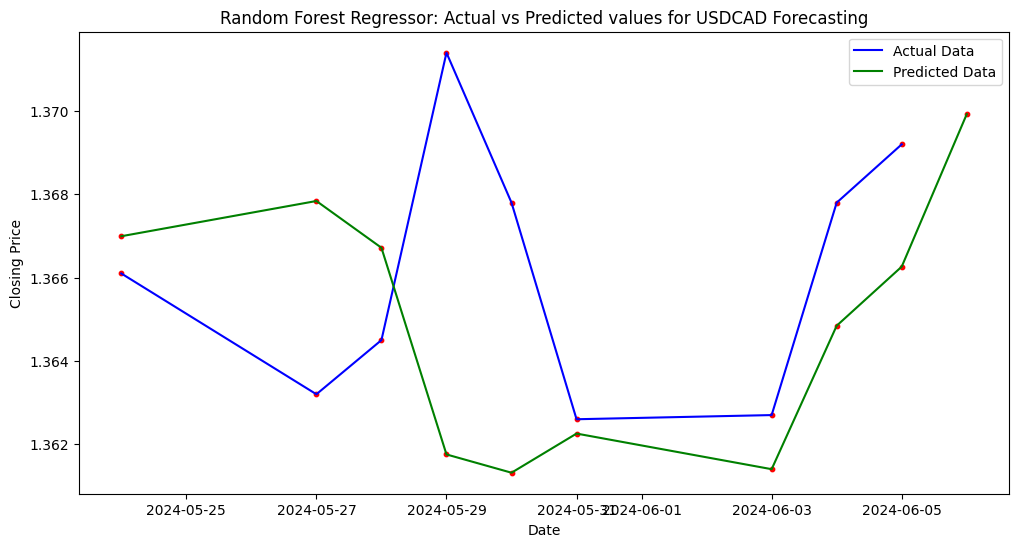

CPU times: user 12 s, sys: 267 ms, total: 12.2 s
Wall time: 12 s


In [40]:
%%time
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=None)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
future_predictions = y_pred[len(y_pred)-(NoOfDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'RFR'
ModelName = 'Random Forest Regressor'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### XGBoost Model

In [41]:
import xgboost as xgb

Mean Absolute Error: 0.002807
Mean Squared Error: 0.000013
Root Mean Squared Error: 0.003609
R-squared (R2) score: 0.992784
Future Predictions [1.3655212 1.3666915 1.3657609 1.3631697 1.361299  1.3616399 1.3592606
 1.3639125 1.3643253 1.3689742]


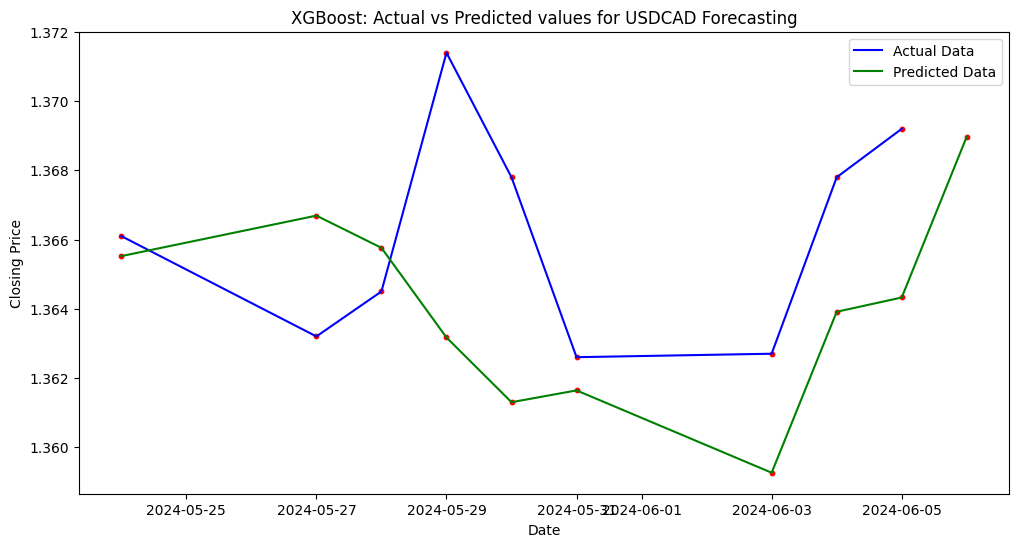

CPU times: user 4.93 s, sys: 250 ms, total: 5.18 s
Wall time: 735 ms


In [42]:
%%time
# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',   # Use squared error loss for regression
    'max_depth': 6,                    # Maximum depth of trees
    'learning_rate': 0.1,              # Learning rate {0.1}
    'n_estimators': 100,               # Number of boosting rounds (trees)
    'seed': 42                         # Random seed for reproducibility {42}
}

# Instantiate XGBoost regressor
xgb_model = xgb.XGBRegressor(**params)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)
future_predictions = y_pred[len(y_pred)-(NoOfDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'XGB'
ModelName = 'XGBoost'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del xgb_model, y_pred, future_predictions

#### Ridge Regression Model

In [43]:
from sklearn.linear_model import Ridge

Mean Absolute Error: 0.002606
Mean Squared Error: 0.000011
Root Mean Squared Error: 0.003360
R-squared (R2) score: 0.993748
Future Predictions [1.36470696 1.36596833 1.36416304 1.36094895 1.35998838 1.3604392
 1.35807895 1.36159394 1.36462908 1.36835091]


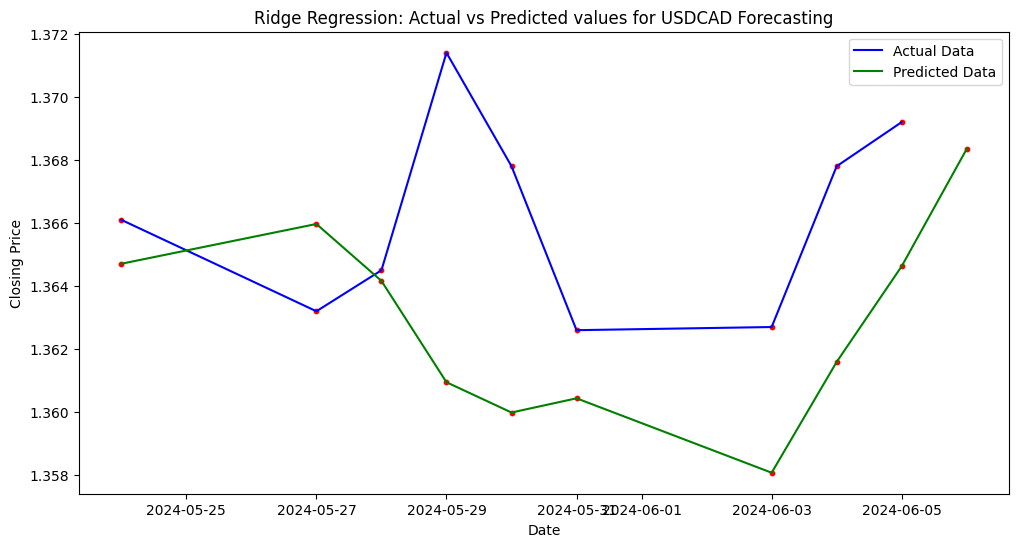

In [44]:
# Instantiate and fit the Ridge Regression model
alpha = 0.1  # Regularization strength (hyperparameter to be tuned)
model = Ridge(alpha=alpha)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[len(y_pred)-(NoOfDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'RIR'
ModelName = 'Ridge Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### Lasso Regression Model

In [45]:
from sklearn.linear_model import Lasso

Mean Absolute Error: 0.041896
Mean Squared Error: 0.002473
Root Mean Squared Error: 0.049725
R-squared (R2) score: -0.369476
Future Predictions [1.29043557 1.29043557 1.29043557 1.29043557 1.29043557 1.29043557
 1.29043557 1.29043557 1.29043557 1.29043557]


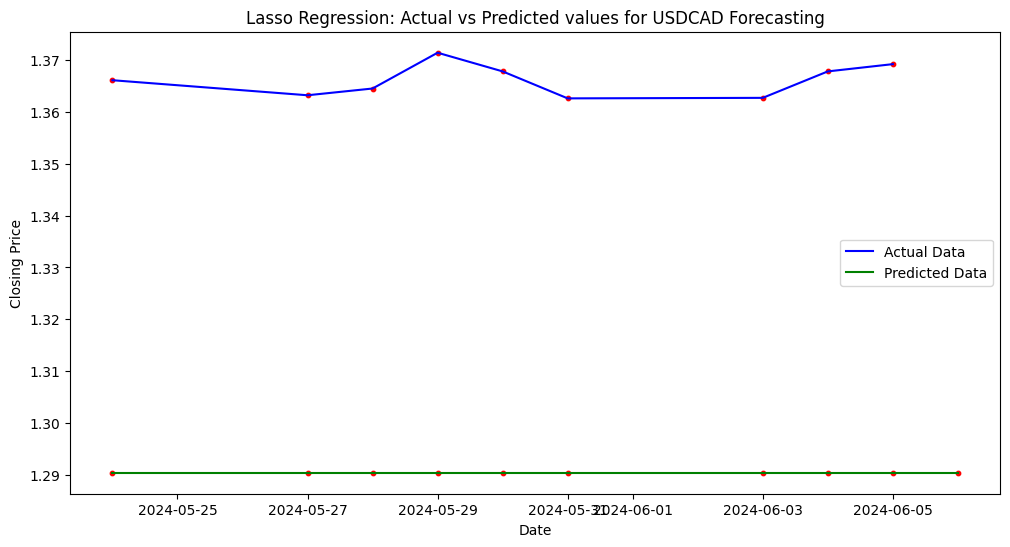

CPU times: user 406 ms, sys: 1.93 s, total: 2.34 s
Wall time: 297 ms


In [46]:
%%time
# Instantiate and fit the Lasso Regression model
alpha = 0.1  # Regularization strength (hyperparameter to be tuned)
model = Lasso(alpha=alpha)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[len(y_pred)-(NoOfDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'LAR'
ModelName = 'Lasso Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### Support Vector Regression (SVR) Model

In [47]:
from sklearn.svm import SVR

Mean Absolute Error: 0.209147
Mean Squared Error: 0.060859
Root Mean Squared Error: 0.246696
R-squared (R2) score: -32.708166
Future Predictions [1.64846722 1.64846722 1.64846722 1.64846722 1.64846722 1.64846722
 1.64846722 1.64846722 1.64846722 1.64846722]


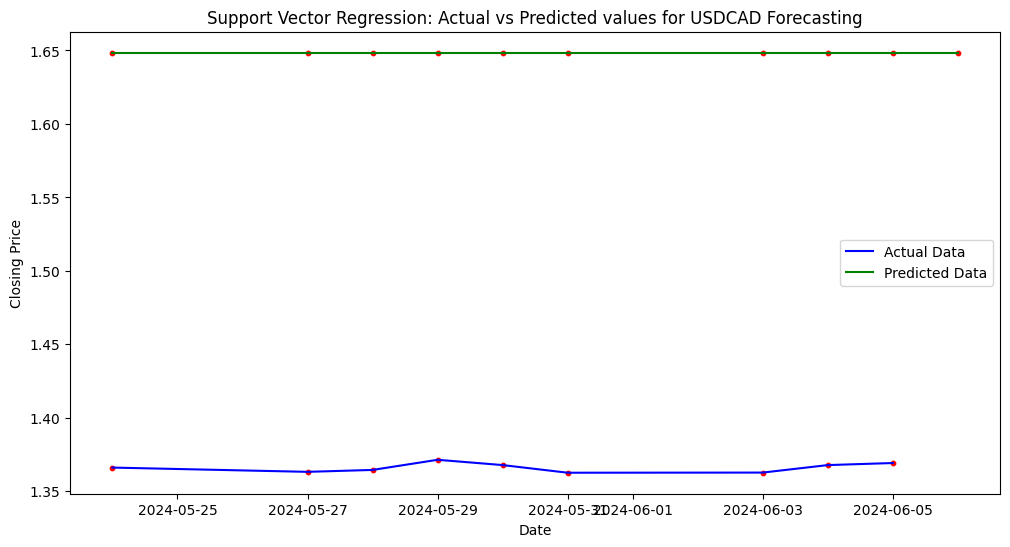

CPU times: user 187 ms, sys: 222 ms, total: 409 ms
Wall time: 174 ms


In [48]:
%%time
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)
future_predictions = y_pred[len(y_pred)-(NoOfDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'SVR'
ModelName = 'Support Vector Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del svr_model, y_pred, future_predictions

#### Bayesian Ridge Regression Model

In [49]:
from sklearn.linear_model import BayesianRidge

Mean Absolute Error: 0.012136
Mean Squared Error: 0.000283
Root Mean Squared Error: 0.016832
R-squared (R2) score: 0.843075
Future Predictions [1.3683264  1.37179554 1.36726294 1.36517292 1.36155752 1.36509949
 1.36391869 1.36019732 1.36299361 1.36458095]


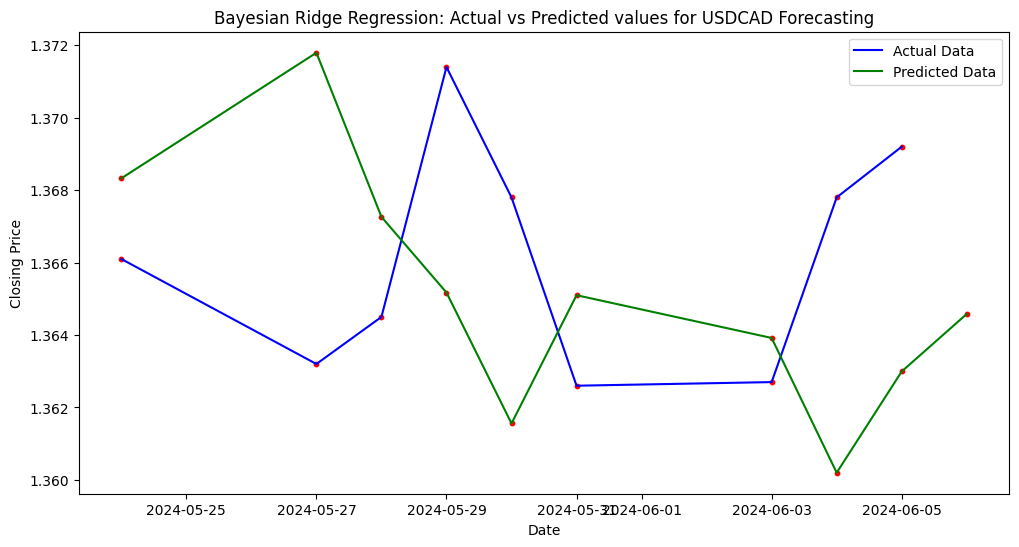

CPU times: user 368 ms, sys: 1.24 s, total: 1.61 s
Wall time: 190 ms


In [50]:
%%time
Baye_model = BayesianRidge()
Baye_model.fit(X_train, y_train)
y_pred = Baye_model.predict(X_test)
future_predictions = y_pred[len(y_pred)-(NoOfDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'BRR'
ModelName = 'Bayesian Ridge Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del Baye_model, y_pred, future_predictions

#### AdaBoost Regression Model

In [51]:
from sklearn.ensemble import AdaBoostRegressor

Mean Absolute Error: 0.005620
Mean Squared Error: 0.000056
Root Mean Squared Error: 0.007465
R-squared (R2) score: 0.969137
Future Predictions [1.37104024 1.37419771 1.37104024 1.36624715 1.36624715 1.3681292
 1.36675935 1.3681292  1.3681292  1.37493902]


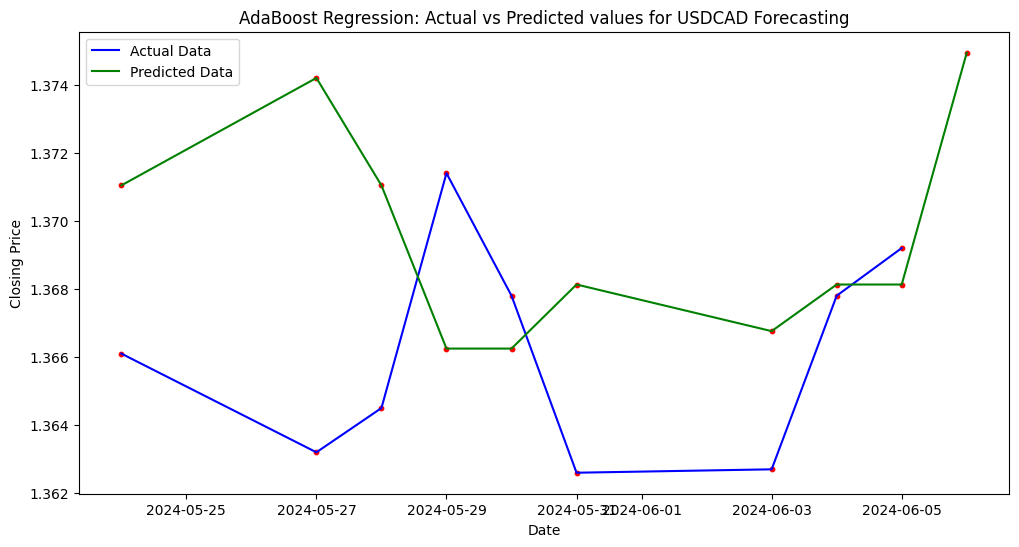

CPU times: user 5.75 s, sys: 239 ms, total: 5.99 s
Wall time: 5.75 s


In [52]:
%%time
AdaB_model = AdaBoostRegressor(n_estimators=100, random_state=None)
AdaB_model.fit(X_train, y_train)
y_pred = AdaB_model.predict(X_test)
future_predictions = y_pred[len(y_pred)-(NoOfDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'ABR'
ModelName = 'AdaBoost Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del AdaB_model, y_pred, future_predictions

In [53]:
# Free the Memory
del FxPair_Data, X, y, X_train, X_test, y_train, y_test

## Summary of the model results

In [54]:
Models_Compare

,ModelName,ModelCode,MAE,MSE,RMSE,R2
0,Linear Regression,LNR,0.002145,0.000007,0.002679,0.996026
1,Random Forest Regressor,RFR,0.002289,0.000009,0.002986,0.995061
2,XGBoost,XGB,0.002807,0.000013,0.003609,0.992784
3,Ridge Regression,RIR,0.002606,0.000011,0.003360,0.993748
4,Lasso Regression,LAR,0.041896,0.002473,0.049725,-0.369476
5,Support Vector Regression,SVR,0.209147,0.060859,0.246696,-32.708166
6,Bayesian Ridge Regression,BRR,0.012136,0.000283,0.016832,0.843075
7,AdaBoost Regression,ABR,0.005620,0.000056,0.007465,0.969137


In [55]:
Models_Compare[['ModelName','MAE','MSE','RMSE','R2']]

,ModelName,MAE,MSE,RMSE,R2
0,Linear Regression,0.002145,0.000007,0.002679,0.996026
1,Random Forest Regressor,0.002289,0.000009,0.002986,0.995061
2,XGBoost,0.002807,0.000013,0.003609,0.992784
3,Ridge Regression,0.002606,0.000011,0.003360,0.993748
4,Lasso Regression,0.041896,0.002473,0.049725,-0.369476
5,Support Vector Regression,0.209147,0.060859,0.246696,-32.708166
6,Bayesian Ridge Regression,0.012136,0.000283,0.016832,0.843075
7,AdaBoost Regression,0.005620,0.000056,0.007465,0.969137
